In [21]:
import random
import numpy as np
import torch
import os
import torchvision
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, random_split, Dataset, Subset

# Use ResNet's default preprocessing pipeline
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()


def load_dataset(split_name: str):
    return torchvision.datasets.OxfordIIITPet(
        root="./data",
        split=split_name,
        target_types="category",
        download=True,
        transform=transform,
    )


train_dataset = load_dataset("trainval")
test_dataset = load_dataset("test")


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Slower, but reproducible
    os.environ['PYTHONHASHSEED'] = str(seed)


global_seed = 42
set_seed(global_seed)
batch_size = 32
num_workers = 2

num_train = int(0.8 * len(train_dataset))
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val],
                                        generator=torch.Generator().manual_seed(42))


# 1) Choose fraction of data to keep as labelled
labelled_fraction = 1
total = len(train_subset)
n_labelled = int(labelled_fraction * total)

# 2) Fix the RNG for reproducibility
g = torch.Generator().manual_seed(global_seed)

# 3) Randomly permute indices, then split
perm = torch.randperm(total, generator=g)
labelled_idx   = perm[:n_labelled].tolist()
unlabelled_idx = perm[n_labelled:].tolist()


labelled_subset   = Subset(train_subset, labelled_idx)
unlabelled_subset = None
if len(unlabelled_idx) > 0:
    unlabelled_subset = Subset(train_subset, unlabelled_idx)

# 4) Wrap the “unlabelled” subset so it only returns the image
class UnlabelledDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        img, *_ = self.ds[i]   # drop all labels
        return img

if unlabelled_subset is not None:
    unlabelled_dataset = UnlabelledDataset(unlabelled_subset)

# 5) Create DataLoaders
labelled_loader = DataLoader(
    labelled_subset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True
)
unlabelled_loader = None
if unlabelled_subset is not None:
    unlabelled_loader = DataLoader(
        unlabelled_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(f" Labelled train size: {len(labelled_loader.dataset)}, Iterations per epoch: {len(labelled_loader)}")
print(f" validation size: {len(val_loader.dataset)}, Iterations per epoch: {len(val_loader)}")

if unlabelled_subset is not None:
    print(f" Unlabelled size: {len(unlabelled_loader.dataset)}, Iterations per epoch: {len(unlabelled_loader)}")

 Labelled train size: 2944, Iterations per epoch: 92
 validation size: 736, Iterations per epoch: 23


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50
model = models.resnet50(weights=weights)

# Freeze earlier layers (improves performance)
freeze_layers = True
if freeze_layers:
    for param in model.parameters():
        param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37)  # Binary classification (cat vs dog)

# Ensure final layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

print(f"GPU acceleration enabled: {'Yes 🚀' if device.type == 'cuda' else 'No 🐌'}")

GPU acceleration enabled: Yes 🚀


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/10]  Loss: 3.2819, Train Acc: 38.25%, Val Acc: 76.36%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/10]  Loss: 2.5157, Train Acc: 80.30%, Val Acc: 82.47%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [3/10]  Loss: 1.9241, Train Acc: 86.18%, Val Acc: 86.28%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [4/10]  Loss: 1.4982, Train Acc: 89.13%, Val Acc: 87.64%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [5/10]  Loss: 1.2101, Train Acc: 90.79%, Val Acc: 88.45%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [6/10]  Loss: 1.0814, Train Acc: 91.20%, Val Acc: 88.45%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [7/10]  Loss: 1.0594, Train Acc: 91.30%, Val Acc: 88.59%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [8/10]  Loss: 1.0347, Train Acc: 91.88%, Val Acc: 88.72%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [9/10]  Loss: 1.0251, Train Acc: 91.13%, Val Acc: 88.04%


Batch:   0%|          | 0/92 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [10/10]  Loss: 1.0029, Train Acc: 91.61%, Val Acc: 88.72%


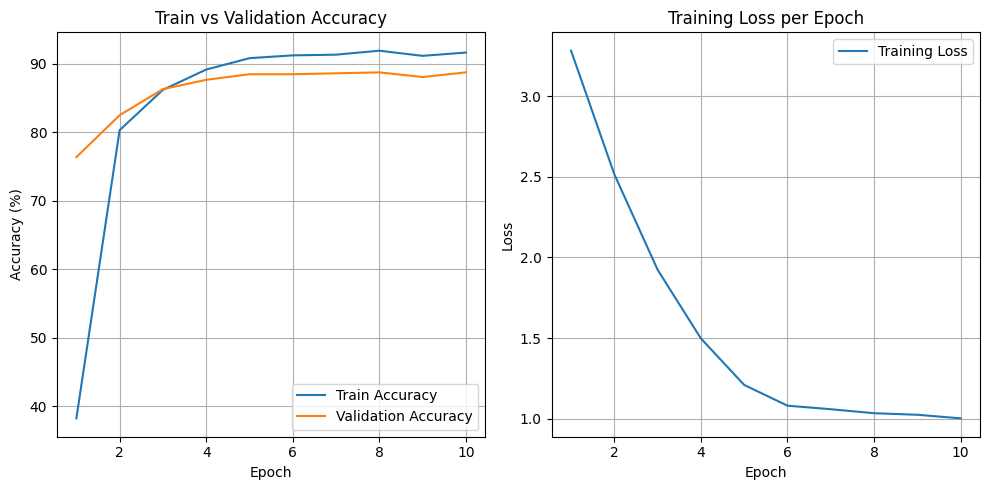

In [23]:
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from typing import Literal


def make_optimizer(optimization: Literal["nag", "adam"]):
    if optimization == "adam":
        return optim.Adam(
            model.fc.parameters(),
            lr=0.001
        )
    elif optimization == "nag":
        return optim.SGD(
            model.fc.parameters(),
            lr=0.001,
            momentum=0.9,
            nesterov=True,
            weight_decay=1e-4,
        )
    else:
        raise NotImplementedError


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total

def backward_pass(model, inputs, labels, criterion, scaler=None):
    if scaler is not None:
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    return outputs, loss

# 2) Setup
optimizer = make_optimizer("nag")              # or "adam"
criterion = nn.CrossEntropyLoss()
enable_mixed_precision = False
scaler = GradScaler() if enable_mixed_precision else None
num_epochs = 10

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare pseudo-label iter if needed
if unlabelled_loader is not None:
    unlab_iter = itertools.cycle(unlabelled_loader)
    unsup_loss = 0.5    # weight for unsupervised loss
    tau      = 0.95     # confidence threshold

# 3) Training loop
train_accuracies = []
val_accuracies   = []
epoch_losses     = []

model.train()
for epoch in tqdm(range(num_epochs), desc="Epoch"):
    running_loss = 0.0
    correct = total = 0

    for inputs, labels in tqdm(labelled_loader, desc="Batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Supervised step
        outputs_l, sup_loss = backward_pass(model, inputs, labels, criterion, scaler)
        running_loss += sup_loss.item()
        _, preds = torch.max(outputs_l.data, 1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        # Unsupervised pseudo-label step (if available)
        if unlabelled_loader is not None:
            #print(f"Unsupervised pseudo-label step")
            x_u = next(unlab_iter).to(device)
            with torch.no_grad():
                logits_u = model(x_u)
                probs_u, pseudo = F.softmax(logits_u, dim=1).max(1)
                mask = probs_u.ge(tau)

            if mask.any():
                inputs_u = x_u[mask]
                labels_u = pseudo[mask]
                _, unsup_loss = backward_pass(model, inputs_u, labels_u, criterion, scaler)
                running_loss += unsup_loss * unsup_loss.item()

    # End of epoch metrics
    train_acc = 100 * correct / total
    epoch_losses.append(running_loss / len(labelled_loader))
    train_accuracies.append(train_acc)

    val_acc = evaluate(model, val_loader, device)
    val_accuracies.append(val_acc)
    val_str = f", Val Acc: {val_acc:.2f}%"

    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}]  "
        f"Loss: {running_loss/len(labelled_loader):.4f}, "
        f"Train Acc: {train_acc:.2f}%{val_str}"
    )
    scheduler.step()

# 4) Plotting results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies,   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("plot1.png")
plt.show()